In [10]:
import os
import warnings
from argparse import ArgumentParser

import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from ignite.contrib.handlers import ProgressBar
from ignite.contrib.handlers.tensorboard_logger import *
from ignite.engine import Events, Engine
from ignite.metrics import RunningAverage, Loss, ConfusionMatrix, IoU
from ignite.utils import convert_tensor
from torch.utils.data import DataLoader

from weathernet.datasets import DENSE, Normalize, Compose, RandomHorizontalFlip
from weathernet.datasets.transforms import ToTensor
from weathernet.model import WeatherNet
from weathernet.utils import save


In [11]:

# I combined e.g. `train_01` and `train_02` into `train`
# `train_road` is all unlabeled, probably it's meant to be augmented
SETS = ['test_01', 'train_01', 'val_01']
#  0: no label, 100: valid/clear, 101: rain, 102: fog
LABEL_NAMES = {0: 'no label', 100: 'clear', 101: 'rain', 102: 'fog'}

sample_file = h5py.File('/home/mcity/Desktop/pytorch-WeatherNet-master/processed_data/test.h5', 'r')
sample_file.keys()
sample_file['distance_m_1'], sample_file['intensity_1'], sample_file['labels_1']

(<HDF5 dataset "distance_m_1": shape (32, 400), type "<f4">,
 <HDF5 dataset "intensity_1": shape (32, 400), type "<f4">,
 <HDF5 dataset "labels_1": shape (32, 400), type "<i8">)

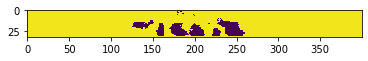

In [13]:
plt.imshow(sample_file['labels_1'])

# Config / Load Model

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_classes = DENSE.num_classes()
model = WeatherNet(num_classes)
model.load_state_dict(torch.load('checkpoints/model_epoch2_mIoU=73.7.pth'))
model.eval()

WeatherNet(
  (lila1): LiLaBlock(
    (branch1): BasicConv2d(
      (conv): Conv2d(2, 32, kernel_size=(7, 3), stride=(1, 1), padding=(2, 0), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): BasicConv2d(
      (conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch3): BasicConv2d(
      (conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch4): BasicConv2d(
      (conv): Conv2d(2, 32, kernel_size=(3, 7), stride=(1, 1), padding=(0, 2), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv): BasicConv2d(
      (conv): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1), padding

# Load in Sample File

In [5]:
sample_file = 'data/DENSE/test_01/2018-11-29_114626_Static2-Day-Clear/LidarImage_000000607.hdf5'
sample_file = h5py.File(sample_file, 'r')

#distance = sample_file['distance_m_1']
#reflexivity = sample_file['intensity_1']

output = model(sample_file, 1)
#prediction = torch.argmax(output)

TypeError: expected Tensor as element 0 in argument 0, but got File